![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [3]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [4]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [5]:
produtos.head()

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado


In [6]:
# criando banco de dados local

engine = create_engine('sqlite:///:memory:')

In [7]:
# criando tabelas no banco de dados

itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
produtos.to_sql('produtos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)


5

In [8]:
# consultando tabelas

inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [9]:
query = "SELECT CONDICAO FROM PRODUTOS"

In [10]:
with engine.connect() as con:
    consulta = con.execute(text(query))
    dados = consulta.fetchall()

pd.DataFrame(dados, columns=consulta.keys())


,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [11]:
# funcao para consultar tabelas

def sql_df(query):
    with engine.connect() as con:
        consulta = con.execute(text(query))
        dados = consulta.fetchall()

    return pd.DataFrame(dados, columns=consulta.keys())


In [12]:
query = ('''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
       FROM PRODUTOS
       GROUP BY CONDICAO''')
sql_df(query)

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


In [13]:
df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


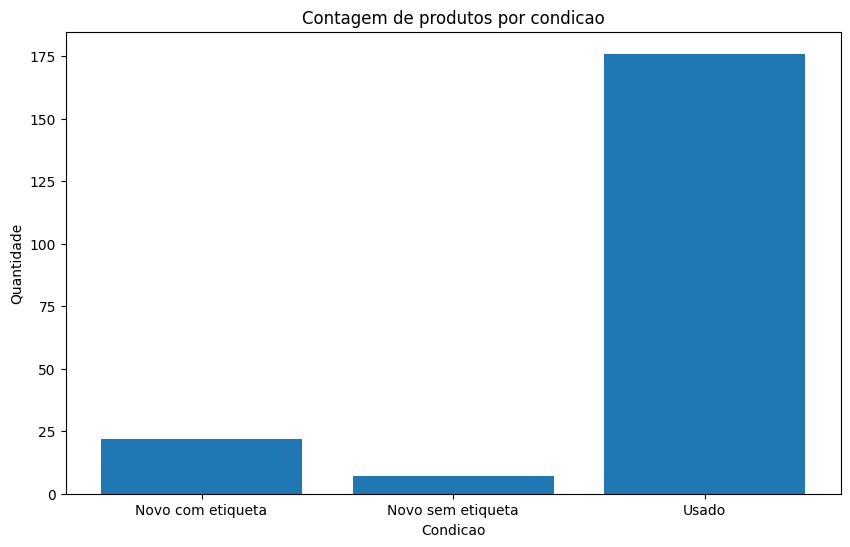

In [14]:
# criando visualizacao barplot

plt.figure(figsize=(10, 6))
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'])
plt.title('Contagem de produtos por condicao')
plt.xlabel('Condicao')
plt.ylabel('Quantidade')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [15]:
sql_df('''SELECT * FROM PRODUTOS''').head()

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado


In [16]:
sql_df('''SELECT * FROM ITENS_PEDIDOS''').head()

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [17]:
# agrupando tabelas PRODUTOS e ITENS_PEDIDOS e criando coluna com total de pedidos

query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS 'quantidade'
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade ASC'''

df_prod_qnt = sql_df(query)
df_prod_qnt

,produto_id,produto,quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,11218,Calca Alfaiataria Preta,750
198,72667,Saia Pregas Preta,751
199,98640,Calca Jeans Costuras,755


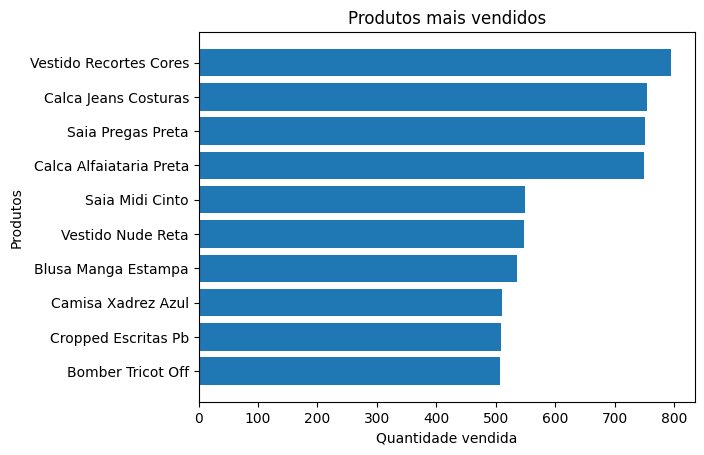

In [18]:
# criando visualizacao barplot

# plt.figure(figsize=(10, 6))
plt.barh(df_prod_qnt['produto'][-10:], df_prod_qnt['quantidade'][-10:])
plt.title('Produtos mais vendidos')
plt.xlabel('Quantidade vendida')
plt.ylabel('Produtos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [19]:
sql_df('SELECT * FROM PEDIDOS').head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [20]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [21]:
query = '''
SELECT * 
FROM PEDIDOS
WHERE STRFTIME('%Y', DATA_COMPRA) = '2020';
 '''

sql_df(query).head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,112772,84743,3,2020-01-01,720
1,112909,56350,3,2020-01-01,1225
2,113068,70673,2,2020-01-01,1050
3,113453,16634,3,2020-01-01,2880
4,114487,43054,1,2020-01-01,640


In [45]:
# selecionando a quentidade de vendedor

query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'vendas', STRFTIME('%Y', DATA_COMPRA) AS 'ano'
FROM PEDIDOS, VENDEDORES 
WHERE STRFTIME('%Y', DATA_COMPRA) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
 '''

vendas_2020 = sql_df(query)
vendas_2020.head()


,nome_vendedor,vendas_media,ano
0,Daniel Siqueira,1972.338526,2020
1,Millena Pereira,1894.614343,2020
2,Ana Duarte,1843.452582,2020
3,Nadia Oliveira,1818.342200,2020
4,Paulo Calanca,1813.469855,2020


In [44]:
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'vendas', STRFTIME('%Y', DATA_COMPRA) AS 'ano'
FROM PEDIDOS, VENDEDORES 
WHERE STRFTIME('%Y', DATA_COMPRA) = '2019' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
 '''

vendas_2019 = sql_df(query)
vendas_2019.head()


,nome_vendedor,vendas,ano
0,Paulo Calanca,2500,2019
1,Nadia Oliveira,1480,2019
2,Ana Duarte,1414,2019
3,Daniel Siqueira,1399,2019
4,Millena Pereira,1374,2019


In [46]:
# valor medio de vendas por vendedor

query = '''
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'vendas_media', STRFTIME('%Y', DATA_COMPRA) AS 'ano'
FROM PEDIDOS, VENDEDORES 
WHERE STRFTIME('%Y', DATA_COMPRA) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
 '''


media_vendas_2020 = sql_df(query)
media_vendas_2020.head()

,nome_vendedor,vendas_media,ano
0,Daniel Siqueira,1972.338526,2020
1,Millena Pereira,1894.614343,2020
2,Ana Duarte,1843.452582,2020
3,Nadia Oliveira,1818.342200,2020
4,Paulo Calanca,1813.469855,2020


In [47]:
# valor medio de vendas por vendedor

query = '''
SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'vendas_media', STRFTIME('%Y', DATA_COMPRA) AS 'ano'
FROM PEDIDOS, VENDEDORES 
WHERE STRFTIME('%Y', DATA_COMPRA) = '2019' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
 '''


media_vendas_2019 = sql_df(query)
media_vendas_2019.head()

,nome_vendedor,vendas_media,ano
0,Nadia Oliveira,1940.022297,2019
1,Ana Duarte,1904.403819,2019
2,Millena Pereira,1869.252547,2019
3,Paulo Calanca,1851.729600,2019
4,Daniel Siqueira,1805.310222,2019


In [59]:
 #exibir os 10 produtos mais vendidos durante o ano de 2019

query = '''SELECT PRODUTOS.PRODUTO, COUNT (PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS
FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY TOTAL_PEDIDOS DESC
LIMIT 10;
'''
sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


In [58]:
# publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021

query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita
FROM pedidos
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY mes;
'''
sql_df(query)

,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [60]:
itens_pedidos.columns

Index(['id_nf', 'produto_id', 'pedido_id', 'quantidade', 'valor_unitario',
       'valor_total', 'Estado', 'frete'],
      dtype='object')

In [62]:
query = '''
SELECT ESTADO, COUNT(*) AS pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY pedidos DESC;
'''

sql_df(query)

,Estado,pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [72]:
query = '''
SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS vendas, ITENS_PEDIDOS.ESTADO AS estado
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY vendas DESC;
'''

sql_df(query)

,nome_vendedor,vendas,estado
0,Daniel Siqueira,190,BR-SP
1,Paulo Calanca,182,BR-SP
2,Nadia Oliveira,181,BR-SP
3,Ana Duarte,180,BR-SP
4,Millena Pereira,157,BR-SP


In [79]:
# listar as marcas vendidas em São Paulo por quantidade de pedidos

query = '''
SELECT PRODUTOS.PRODUTO, COUNT(*) AS 'produtos_vendidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''

sql_df(query)

,produto,produtos_vendidos
0,Blusa Preta Aplicacao,100
1,Camiseta Eternity,58
2,Macacao Malha Preto,44
3,Cardigan Fio Floral,26
4,Calca Jeans Basica,18
...,...,...
111,Cropped Listras Florzinhas,1
112,Regata Alcinha Paete,1
113,Saia Costura Preta,1
114,Camisa Fio Animalprint,1


In [86]:
# publicar os produtos que são mais vendidos na época de Natal no Brasil todo

query = '''
SELECT PRODUTOS.PRODUTO, COUNT(*) AS 'produtos_vendidos', strftime('%m', PEDIDOS.DATA_COMPRA) AS 'mes_natal'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m', PEDIDOS.DATA_COMPRA) = '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''

sql_df(query)


,produto,produtos_vendidos,mes_natal
0,Vestido Recortes Cores,30,12
1,Vestido Preto Franzido,26,12
2,Calca Jeans Costuras,26,12
3,Calca Alfaiataria Preta,26,12
4,Camisa Xadrez Azul,25,12
...,...,...,...
196,Sneaker Monograma Bege,6,12
197,Casaqueto Estampa Geometrica,6,12
198,Regata Renda Branca,5,12
199,Body Estampa Coracoes,5,12
